In [32]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import ncx2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [33]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

Task 1. Simulate a Cox-Ingersoll-Ross (CIR) model
$$
dX_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}dW_t
$$
with $\theta = (6, 2, 1)$, and choose the bandwidth according to Scott’s rule and implement the non-parametric kernel estimation for stationary density of the CIR model.

Plot in a graph the true stationary density against the estimated one for two approaches
*  compute on the single trajectory  (set $T$ very large, time discretization step set as $T/N_t = \Delta t$);
*  compute on the Nx trajectories.




In [34]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [35]:
# approach 1

Nx = 1
Nt = 100000
T = 1000

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

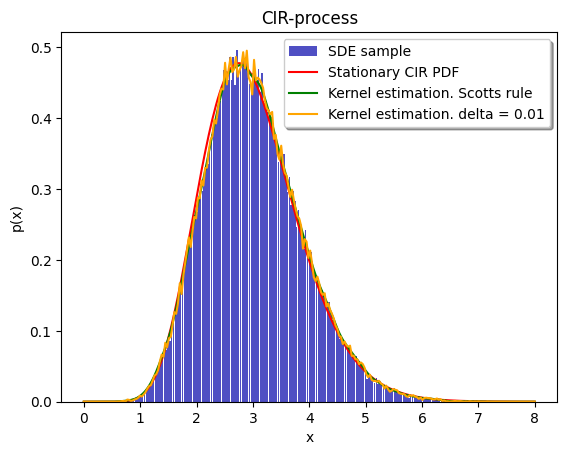

In [36]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR.flatten(), bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [37]:
# approach 2

Nx = 15000
Nt = 300

T = 1

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

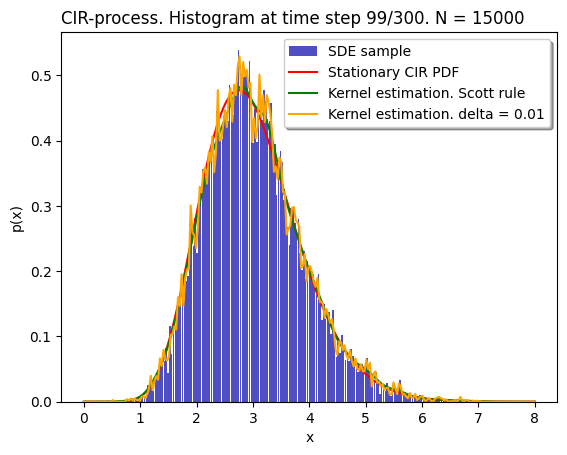

In [38]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

Task. Estimate the quality of the obtained approximations with statistical criteria and provide conclusions.

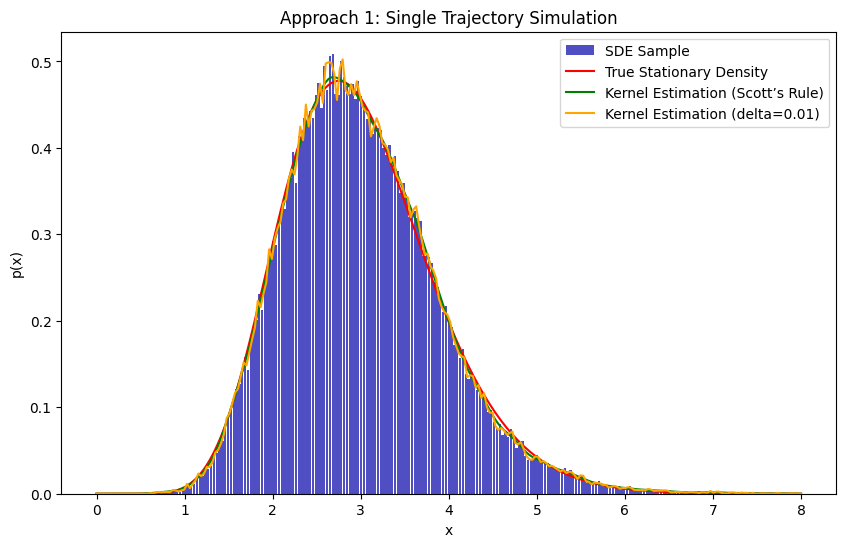

Approach 1: Single Trajectory Simulation
MISE (Scott’s Rule): 0.000140
Max AE (Scott’s Rule): 0.015445
MISE (delta=0.01): 0.000458
Max AE (delta=0.01): 0.032899
--------------------------------------------------


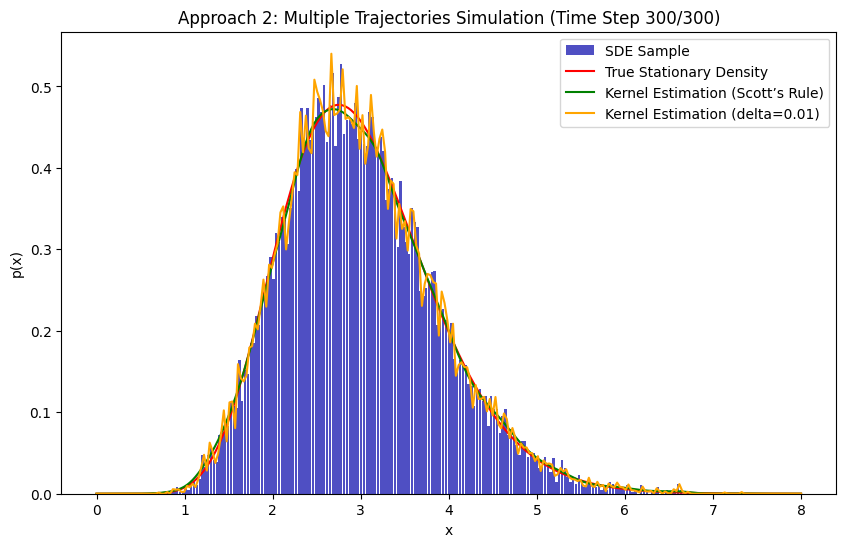

Approach 2: Multiple Trajectories Simulation
MISE (Scott’s Rule): 0.000103
Max AE (Scott’s Rule): 0.011073
MISE (delta=0.01): 0.002021
Max AE (delta=0.01): 0.065159
--------------------------------------------------


In [39]:

def compute_MISE(p_est, p_true, x):
    """
    Compute Mean Integrated Squared Error (MISE) between estimated and true densities.
    
    Parameters:
        p_est (array): Estimated density values.
        p_true (array): True density values.
        x (array): Points at which densities are evaluated.
    
    Returns:
        float: MISE value.
    """
    squared_error = (p_est - p_true) ** 2
    # Use the trapezoidal rule for numerical integration
    MISE = np.trapz(squared_error, x)
    return MISE

def compute_MaxAE(p_est, p_true):
    """
    Compute Maximum Absolute Error (Max AE) between estimated and true densities.
    
    Parameters:
        p_est (array): Estimated density values.
        p_true (array): True density values.
    
    Returns:
        float: Max AE value.
    """
    max_ae = np.max(np.abs(p_est - p_true))
    return max_ae

def true_stationary_density(x, cir_process):
    return cir_process.StationaryDistribution(x)

def StationaryDistributionKernelEstimator(x, x_data, delta=None):
    n = len(x_data)
    m = 1  # Dimension
    if delta is None:
        # Scott's rule: bandwidth = std * n^(-1/(m+4))
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))
    for j in range(len(x)):
        K = (1 / (np.sqrt(2 * np.pi) * hn)) * np.exp(-0.5 * ((x[j] - x_data) / hn) ** 2)
        pi[j] = np.sum(K) / n
    return pi

def approach1_evaluation(cir_process, x, p_true):
    # Approach 1: Single trajectory
    Nx = 1
    Nt = 100000
    T = 1000

    cir_process1 = CIRprocess(cir_process.params, T, Nx, Nt)
    cir_process1.init_state = cir_process1.StationaryState()
    t_data, x_data_CIR = cir_process1.ExactSolution()

    p_est_scott = StationaryDistributionKernelEstimator(x, x_data_CIR.flatten())
    p_est_fixed = StationaryDistributionKernelEstimator(x, x_data_CIR.flatten(), delta=0.01)
    MISE_scott = compute_MISE(p_est_scott, p_true, x)
    MaxAE_scott = compute_MaxAE(p_est_scott, p_true)

    MISE_fixed = compute_MISE(p_est_fixed, p_true, x)
    MaxAE_fixed = compute_MaxAE(p_est_fixed, p_true)

    plt.figure(figsize=(10, 6))
    plt.hist(x_data_CIR.flatten(), bins=x, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label='SDE Sample')
    plt.plot(x, p_true, label='True Stationary Density', color='red')
    plt.plot(x, p_est_scott, label='Kernel Estimation (Scott’s Rule)', color='green')
    plt.plot(x, p_est_fixed, label='Kernel Estimation (delta=0.01)', color='orange')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.title('Approach 1: Single Trajectory Simulation')
    plt.legend(loc='upper right')
    plt.show()

    print("Approach 1: Single Trajectory Simulation")
    print(f"MISE (Scott’s Rule): {MISE_scott:.6f}")
    print(f"Max AE (Scott’s Rule): {MaxAE_scott:.6f}")
    print(f"MISE (delta=0.01): {MISE_fixed:.6f}")
    print(f"Max AE (delta=0.01): {MaxAE_fixed:.6f}")
    print("-" * 50)

def approach2_evaluation(cir_process, x, p_true):
    Nx = 15000
    Nt = 300
    T = 1

    cir_process2 = CIRprocess(cir_process.params, T, Nx, Nt)
    cir_process2.init_state = cir_process2.StationaryState()
    t_data, x_data_CIR = cir_process2.ExactSolution()

    i = Nt  

    p_est_scott = StationaryDistributionKernelEstimator(x, x_data_CIR[i])
    p_est_fixed = StationaryDistributionKernelEstimator(x, x_data_CIR[i], delta=0.01)

    MISE_scott = compute_MISE(p_est_scott, p_true, x)
    MaxAE_scott = compute_MaxAE(p_est_scott, p_true)

    MISE_fixed = compute_MISE(p_est_fixed, p_true, x)
    MaxAE_fixed = compute_MaxAE(p_est_fixed, p_true)

    plt.figure(figsize=(10, 6))
    plt.hist(x_data_CIR[i], bins=x, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label='SDE Sample')
    plt.plot(x, p_true, label='True Stationary Density', color='red')
    plt.plot(x, p_est_scott, label='Kernel Estimation (Scott’s Rule)', color='green')
    plt.plot(x, p_est_fixed, label='Kernel Estimation (delta=0.01)', color='orange')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.title(f'Approach 2: Multiple Trajectories Simulation (Time Step {i}/{Nt})')
    plt.legend(loc='upper right')
    plt.show()

    print("Approach 2: Multiple Trajectories Simulation")
    print(f"MISE (Scott’s Rule): {MISE_scott:.6f}")
    print(f"Max AE (Scott’s Rule): {MaxAE_scott:.6f}")
    print(f"MISE (delta=0.01): {MISE_fixed:.6f}")
    print(f"Max AE (delta=0.01): {MaxAE_fixed:.6f}")
    print("-" * 50)

params_CIR = [6, 2, 1]  # theta
Nx_initial = 1
Nt_initial = 1000 
T_initial = 1000

CIRp = CIRprocess(params_CIR, T_initial, Nx_initial, Nt_initial)
CIRp.init_state = CIRp.StationaryState()

x_grid = np.linspace(0, 8, 250)
p_true = true_stationary_density(x_grid, CIRp)

approach1_evaluation(CIRp, x_grid, p_true)

approach2_evaluation(CIRp, x_grid, p_true)




Task. Study the effect of the bandwidth $h_n$ and the mesh $∆_n$ on the kernel estimator and plot a 3D graph.

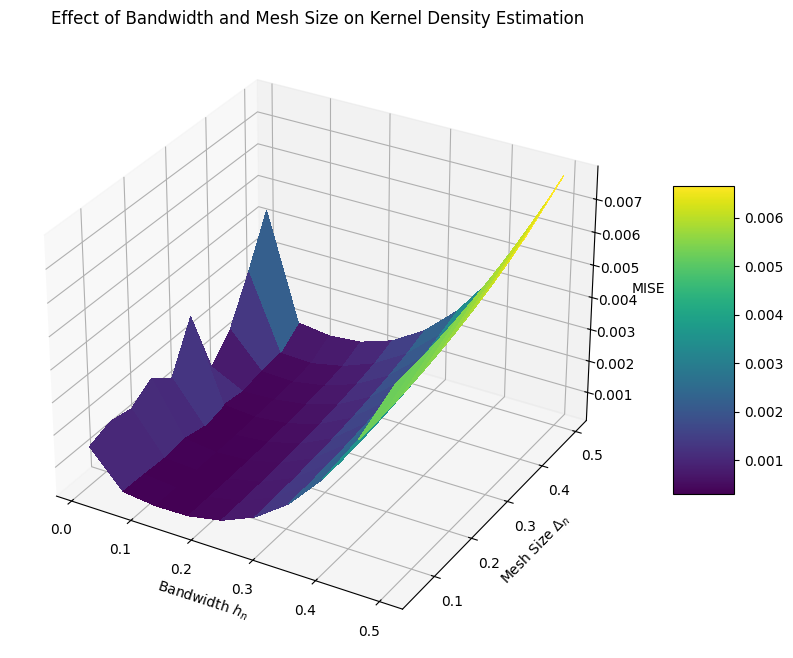

In [40]:
def StationaryDistributionKernelEstimator(x, x_data, delta=None):
    n = len(x_data)
    m = 1
    
    if delta is None:
        # Scott's rule: bandwidth = std * n^(-1/(m+4))
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta
    
    pi = np.zeros(len(x))
    for j in range(len(x)):
        K = (1 / (np.sqrt(2 * np.pi) * hn)) * np.exp(-0.5 * ((x[j] - x_data) / hn) ** 2)
        pi[j] = np.sum(K) / n
    return pi

def compute_MISE(p_est, p_true, x):
    """
    Compute Mean Integrated Squared Error (MISE) between estimated and true densities.
    
    Parameters:
        p_est (array): Estimated density values.
        p_true (array): True density values.
        x (array): Points at which densities are evaluated.
    
    Returns:
        float: MISE value.
    """
    squared_error = (p_est - p_true) ** 2
    MISE = np.trapz(squared_error, x)
    return MISE

params_CIR = [6, 2, 1]  # theta
Nx_initial = 1
Nt_initial = 1000 
T_initial = 1000

CIRp = CIRprocess(params_CIR, T_initial, Nx_initial, Nt_initial)
CIRp.init_state = CIRp.StationaryState()

x_grid = np.linspace(0, 8, 250)
p_true = CIRp.StationaryDistribution(x_grid)
bandwidths = np.linspace(0.01, 0.5, 10) 
mesh_sizes = np.linspace(0.05, 0.5, 10) 

H, D = np.meshgrid(bandwidths, mesh_sizes)
MISE_matrix = np.zeros_like(H)

Nx = 15000
Nt = 300
T = 1

CIRp_multi = CIRprocess(params_CIR, T, Nx, Nt)
CIRp_multi.init_state = CIRp_multi.StationaryState()
t_data, x_data_CIR_multi = CIRp_multi.ExactSolution()

i = Nt
x_samples = x_data_CIR_multi[i]

def true_stationary_density(x, cir_process):
    return cir_process.StationaryDistribution(x)

p_true = true_stationary_density(x_grid, CIRp)

for idx in range(H.shape[0]):
    for jdx in range(H.shape[1]):
        hn = H[idx, jdx]
        delta = D[idx, jdx]
        
        x_eval = np.arange(0, 8 + delta, delta)
        p_est = StationaryDistributionKernelEstimator(x_eval, x_samples, delta=hn)
        p_est_interp = np.interp(x_grid, x_eval, p_est)
        
        MISE = compute_MISE(p_est_interp, p_true, x_grid)
        MISE_matrix[idx, jdx] = MISE

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(H, D, MISE_matrix, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel('Bandwidth $h_n$')
ax.set_ylabel('Mesh Size $\Delta_n$')
ax.set_zlabel('MISE')
ax.set_title('Effect of Bandwidth and Mesh Size on Kernel Density Estimation')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


Task. Repeat previos tasks on the Chan-Karolyi-Longstaff-Sanders (CKLS) model
\begin{equation*}%\label{eq09}
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
\end{equation*}
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

Variance at time step 299: 7.044061714419688


C:\Users\smart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\smart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


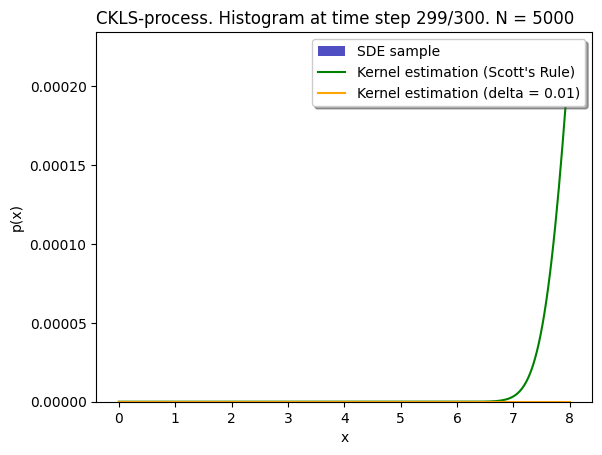

Kolmogorov-Smirnov test between Scott's Rule and delta=0.01: statistic=0.892000, p-value=0.000000
Cramer-von Mises test between Scott's Rule and delta=0.01: statistic=43.994540, p-value=0.000000
KL Divergence D(Scott's Rule || delta=0.01): 2.456713
Mann-Whitney U test between Scott's Rule and delta=0.01: statistic=6750.000000, p-value=0.000000
Wilcoxon test between Scott's Rule and delta=0.01: statistic=5517.000000, p-value=0.000000
                     Statistic        P-value
Criteria                                     
Kolmogorov-Smirnov     0.89200  5.735791e-105
Cramer von Mises      43.99454   7.920642e-09
Mann-Whitney        6750.00000   2.094323e-62
Wilcoxon            5517.00000   9.861699e-21


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import ks_2samp, cramervonmises_2samp, entropy, mannwhitneyu, wilcoxon
from tqdm import tqdm
import pandas as pd


class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = np.array(params, dtype=np.float64)
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0.0, np.sqrt(dt), size=(self.Nt, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_prev = x_data[i - 1]
            x_prev = np.maximum(x_prev, 1e-6)
            drift = self.bxt(x_prev, t_data[i - 1], self.params)
            diffusion = self.sigmaxt(x_prev, t_data[i - 1], self.params)

            x_new = x_prev + drift * dt + diffusion * dwt[i - 1]

            x_new = np.maximum(x_new, 1e-6)
            x_data[i] = x_new

        return t_data, x_data

    @staticmethod
    def bxt(x, t, params):
        pass

    @staticmethod
    def sigmaxt(x, t, params):
        pass

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

    @staticmethod
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    def sigmaxt(x, t, params):
        return params[2] * np.power(x, params[3])

    def DefaultInitState(self):
        # Ensure the initial state is positive
        x0 = -params[0] / params[1]
        x0 = np.maximum(x0, 1e-6)
        return x0 * np.ones(self.Nx, dtype=np.float64)
    
def StationaryDistributionKernelEstimator(x, x_data, h_n=None, delta=None):
    n = len(x_data)
    m = 1 

    if h_n is not None:
        bandwidth = h_n
    elif delta is not None:
        bandwidth = delta
    else:
        # Scott's rule: bandwidth = std * n^(-1/(m+4))
        bandwidth = np.std(x_data) * n ** (-1 / (m + 4))

    x_data = x_data[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x_data)
    log_density = kde.score_samples(x[:, np.newaxis])
    return np.exp(log_density)

Nx = 5000 
Nt = 300
T = 1
params_CKLS = [1.0, 2.0, 0.5, 0.3]

CKLS = CKLSprocess(params_CKLS, T, Nx, Nt)
CKLS.init_state = 2 * np.ones(Nx, dtype=np.float64)
t_data, x_data_CKLS = CKLS.EulerSolution()

i = Nt - 1

variance = np.var(x_data_CKLS[i])
print(f"Variance at time step {i}: {variance}")
if variance < 1e-8:
    raise ValueError("Variance too low for KDE")

fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

n, bins, patches = ax.hist(
    x_data_CKLS[i],
    bins=x_data,
    density=True,
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85,
    label='SDE sample'
)
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CKLS-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc='left')

ax.plot(
    x_data,
    StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i]),
    label='Kernel estimation (Scott\'s Rule)',
    color='green'
)

d = 0.01
ax.plot(
    x_data,
    StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta=d),
    label=f'Kernel estimation (delta = {d})',
    color='orange'
)

ax.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

CKLS_Scott = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i])
CKLS_Delta = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta=d)

CKLS_Scott = np.maximum(CKLS_Scott, 1e-10)
CKLS_Delta = np.maximum(CKLS_Delta, 1e-10)

CKLS_Scott /= np.trapz(CKLS_Scott, x_data)
CKLS_Delta /= np.trapz(CKLS_Delta, x_data)

KS_stat_Scott_vs_Delta, KS_p_value_Scott_vs_Delta = ks_2samp(CKLS_Scott, CKLS_Delta)
print(f"Kolmogorov-Smirnov test between Scott's Rule and delta={d}: statistic={KS_stat_Scott_vs_Delta:.6f}, p-value={KS_p_value_Scott_vs_Delta:.6f}")

CM_result_Scott_vs_Delta = cramervonmises_2samp(CKLS_Scott, CKLS_Delta)
print(f"Cramer-von Mises test between Scott's Rule and delta={d}: statistic={CM_result_Scott_vs_Delta.statistic:.6f}, p-value={CM_result_Scott_vs_Delta.pvalue:.6f}")

kl_divergence_Scott_vs_Delta = entropy(CKLS_Scott, CKLS_Delta)
print(f"KL Divergence D(Scott's Rule || delta={d}): {kl_divergence_Scott_vs_Delta:.6f}")

MW_stat_Scott_vs_Delta, MW_p_value_Scott_vs_Delta = mannwhitneyu(CKLS_Scott, CKLS_Delta, alternative='two-sided')
print(f"Mann-Whitney U test between Scott's Rule and delta={d}: statistic={MW_stat_Scott_vs_Delta:.6f}, p-value={MW_p_value_Scott_vs_Delta:.6f}")

W_stat_Scott_vs_Delta, W_p_value_Scott_vs_Delta = wilcoxon(CKLS_Scott, CKLS_Delta)
print(f"Wilcoxon test between Scott's Rule and delta={d}: statistic={W_stat_Scott_vs_Delta:.6f}, p-value={W_p_value_Scott_vs_Delta:.6f}")

df = pd.DataFrame([
    ['Kolmogorov-Smirnov', KS_stat_Scott_vs_Delta, KS_p_value_Scott_vs_Delta],
    ['Cramer von Mises', CM_result_Scott_vs_Delta.statistic, CM_result_Scott_vs_Delta.pvalue],
    ['Mann-Whitney', MW_stat_Scott_vs_Delta, MW_p_value_Scott_vs_Delta],
    ['Wilcoxon', W_stat_Scott_vs_Delta, W_p_value_Scott_vs_Delta]
], columns=['Criteria', 'Statistic', 'P-value'])

print(df.set_index('Criteria'))


Task 2. Implement a non-parametric drift estimator

$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}
$$

and diffusion estimator
$$
\hat{\sigma}^2_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)^2} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}.$$


for the CIR model (Task 1) and plot two graphs.
Use the Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$.


In [42]:
from typing import Literal

def NormalKernel(z):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * z**2)

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def ParabolicKernel(z):
    return 3/4 * (1 - z**2)

def DiffusionKernelEstimator(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [43]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

C:\Users\smart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CIRprocess.sigmaxt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\AppData\Local\Temp\ipykernel_9640\2663539421.py", line 99:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


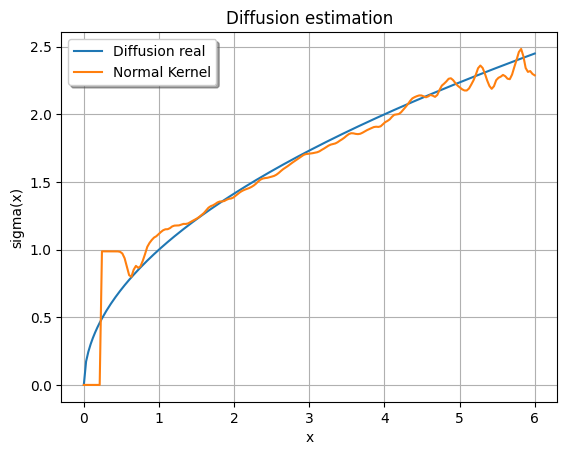

In [44]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, np.sqrt(diffke), label = 'Parabolic Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, np.sqrt(diffke), label = 'Uniform Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

C:\Users\smart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CIRprocess.bxt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\AppData\Local\Temp\ipykernel_9640\2663539421.py", line 94:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


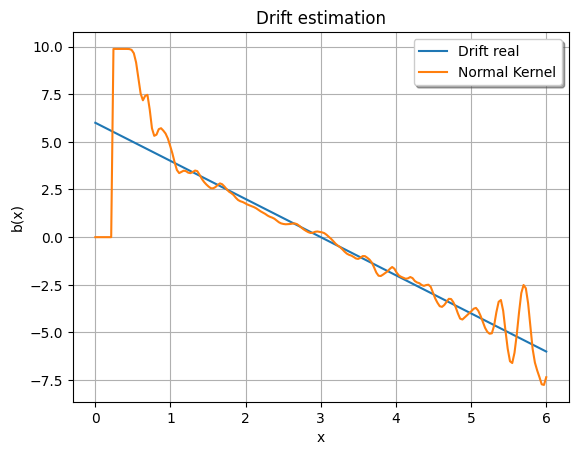

In [45]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, driftke, label = 'Parabolic Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, driftke, label = 'Uniform Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()

Task. Implement a non-parametric drift
and diffusion estimators with the higher order Gaussian kernel $K(u)=\frac{3}{\sqrt{8 \pi}}(1-u^2/3)\exp({-u^2/2})$ ([p.24](https://www.nber.org/system/files/working_papers/w5345/w5345.pdf))  and add curves on graphs
for the CIR model.

Improve estimates on the left and the right subintervals $[0,1]$ and $[5,6]$ respectly.


C:\Users\smart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CIRprocess.sigmaxt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\AppData\Local\Temp\ipykernel_9640\671202505.py", line 123:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


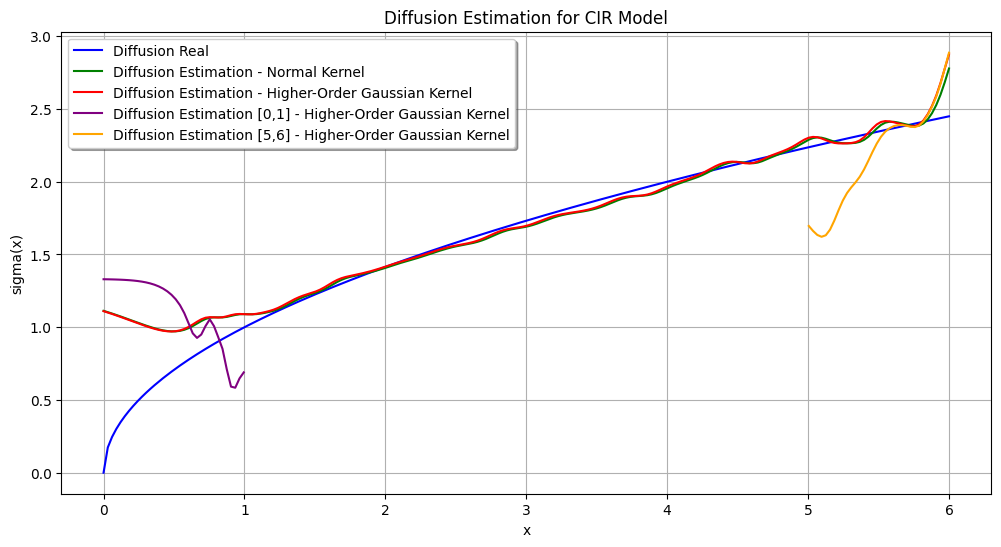

C:\Users\smart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CIRprocess.bxt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\AppData\Local\Temp\ipykernel_9640\671202505.py", line 117:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


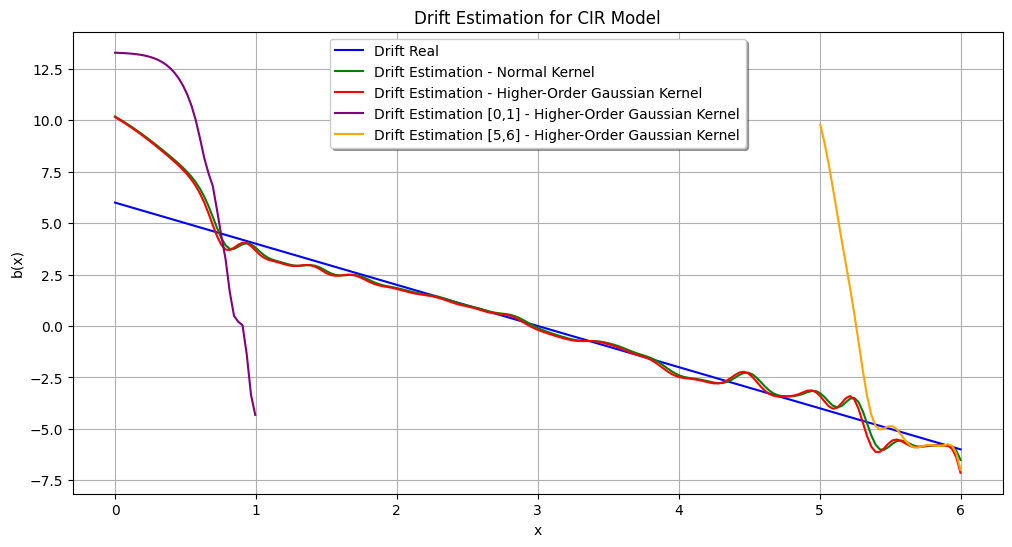

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from typing import Literal
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx  
        self.Nt = Nt 
        self.init_state = init_state

    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0.0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1.0

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0.0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0.0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0.0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0.0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0.0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0.0, 1.0, size=(self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_prev = x_data[i - 1]
            drift = self.bxt(x_prev, t_data[i - 1], self.params)
            diffusion = self.sigmaxt(x_prev, t_data[i - 1], self.params)
            x_data[i] = x_prev + drift * dt + diffusion * dwt[i - 1]
        return t_data, x_data

    def MilsteinSolution(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0.0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0.0, 1.0, size=(self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_prev = x_data[i - 1]
            drift = self.bxt(x_prev, t_data[i - 1], self.params)
            diffusion = self.sigmaxt(x_prev, t_data[i - 1], self.params)
            diffusion_x = self.sigmaxt_x(x_prev, t_data[i - 1], self.params)

            x_data[i] = (
                x_prev
                + drift * dt
                + diffusion * dwt[i - 1]
                + 0.5 * diffusion_x * diffusion * (dwt[i - 1] ** 2 - dt)
            )
        return t_data, x_data

class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x, 0.0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0.0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] / (2.0 * np.sqrt(np.maximum(x, 1e-10)))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] / (4.0 * np.power(np.maximum(x, 1e-10), 1.5))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0.0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0.0, 1.0, size=(self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1 / theta2
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0.0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

def NormalKernel(z):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * z**2)

def HigherOrderGaussianKernel(z):
    return 3 / np.sqrt(8 * np.pi) * (1 - z / 3) * np.exp(-0.5 * z**2)

def UniformKernel(z):
    return 0.5 * np.ones_like(z)

def ParabolicKernel(z):
    return 0.75 * (1 - z**2)

def DriftKernelEstimator(x, x_data, delta=None, method: Literal['normal', 'higher_normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    if delta is None:
        delta = 1.0

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s = np.zeros(len(x))

    for j in range(len(x)):
        if method == 'normal':
            K = NormalKernel((x[j] - x_data) / hn)
        elif method == 'higher_normal':
            u = (x[j] - x_data) / hn
            K = HigherOrderGaussianKernel(u)
        elif method == 'uniform':
            K = UniformKernel((x[j] - x_data) / hn)
        elif method == 'parabolic':
            K = ParabolicKernel((x[j] - x_data) / hn)
        else:
            raise ValueError(f"Method {method} not implemented.")

        K = K[:n-1]  # Exclude the last point for X_{i+1}
        delta_X = x_data[1:] - x_data[:-1]
        numerator = np.sum(K * delta_X)
        denominator = np.sum(K)
        if denominator == 0:
            s[j] = 0.0
        else:
            s[j] = numerator / denominator

    return s / delta

def DiffusionKernelEstimator(x, x_data, delta=None, method: Literal['normal', 'higher_normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    if delta is None:
        delta = 1.0 

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(len(x)):
        if method == 'normal':
            K = NormalKernel((x[j] - x_data) / hn)
        elif method == 'higher_normal':
            u = (x[j] - x_data) / hn
            K = HigherOrderGaussianKernel(u)
        elif method == 'uniform':
            K = UniformKernel((x[j] - x_data) / hn)
        elif method == 'parabolic':
            K = ParabolicKernel((x[j] - x_data) / hn)
        else:
            raise ValueError(f"Method {method} not implemented.")

        K = K[:n-1]  # Exclude the last point for X_{i+1}
        delta_X = x_data[1:] - x_data[:-1]
        numerator = np.sum(K * (delta_X ** 2))
        denominator = np.sum(K)
        if denominator == 0:
            s2[j] = 0.0
        else:
            s2[j] = numerator / denominator

    if delta == 0:
        delta = 1.0 

    return s2 / delta

params_CIR = [6.0, 2.0, 1.0]  # [theta1, theta2, theta3]
Nx = 1
Nt = 100000
T = 1000.0

x_data = np.linspace(0, 6, 200)

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

sigma_data = CIRp.sigmaxt(x_data, 0.0, CIRp.params)

plt.figure(figsize=(12, 6))
plt.plot(x_data, sigma_data, label='Diffusion Real', color='blue')

diffke_normal = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), delta=T/Nt, method='normal')
plt.plot(x_data, np.sqrt(diffke_normal), label='Diffusion Estimation - Normal Kernel', color='green')

diffke_higher = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), delta=T/Nt, method='higher_normal')
plt.plot(x_data, np.sqrt(diffke_higher), label='Diffusion Estimation - Higher-Order Gaussian Kernel', color='red')

mask_left = x_data_CIR.flatten() <= 1.0
diffke_left = DiffusionKernelEstimator(x_data[x_data <=1.0], x_data_CIR.flatten()[mask_left], delta=T/Nt, method='higher_normal')
plt.plot(x_data[x_data <=1.0], np.sqrt(diffke_left), label='Diffusion Estimation [0,1] - Higher-Order Gaussian Kernel', color='purple')

mask_right = x_data_CIR.flatten() >=5.0
diffke_right = DiffusionKernelEstimator(x_data[x_data >=5.0], x_data_CIR.flatten()[mask_right], delta=T/Nt, method='higher_normal')
plt.plot(x_data[x_data >=5.0], np.sqrt(diffke_right), label='Diffusion Estimation [5,6] - Higher-Order Gaussian Kernel', color='orange')

plt.title("Diffusion Estimation for CIR Model")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

b_data = CIRp.bxt(x_data, 0.0, CIRp.params)

plt.figure(figsize=(12, 6))
plt.plot(x_data, b_data, label='Drift Real', color='blue')

driftke_normal = DriftKernelEstimator(x_data, x_data_CIR.flatten(), delta=T/Nt, method='normal')
plt.plot(x_data, driftke_normal, label='Drift Estimation - Normal Kernel', color='green')

driftke_higher = DriftKernelEstimator(x_data, x_data_CIR.flatten(), delta=T/Nt, method='higher_normal')
plt.plot(x_data, driftke_higher, label='Drift Estimation - Higher-Order Gaussian Kernel', color='red')

driftke_left = DriftKernelEstimator(x_data[x_data <=1.0], x_data_CIR.flatten()[mask_left], delta=T/Nt, method='higher_normal')
plt.plot(x_data[x_data <=1.0], driftke_left, label='Drift Estimation [0,1] - Higher-Order Gaussian Kernel', color='purple')

driftke_right = DriftKernelEstimator(x_data[x_data >=5.0], x_data_CIR.flatten()[mask_right], delta=T/Nt, method='higher_normal')
plt.plot(x_data[x_data >=5.0], driftke_right, label='Drift Estimation [5,6] - Higher-Order Gaussian Kernel', color='orange')

plt.title("Drift Estimation for CIR Model")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()